In [1]:
!pip install torch
!pip install anndata
!pip install scvi
!pip install scanpy

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc

/Users/apawar/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.4.6 anndata==0.7.1 umap==0.4.3 numpy==1.18.5 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0


In [6]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

## Read the Data file

#### Read in the count matrix into an `AnnData <https://anndata.readthedocs.io/en/latest/anndata.AnnData.html>`__ object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: .h5ad.

In [7]:
adata = sc.read_10x_mtx(
    '/Users/apawar/Downloads/Surface_Oncology/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading



... reading from cache file cache/Users-apawar-Downloads-Surface_Oncology-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [16]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [17]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

#### Another method to read the Anndata Object

In [27]:
path = '/Users/apawar/Downloads/Surface_Oncology/filtered_gene_bc_matrices/hg19/'
adata = sc.read(path + 'matrix.mtx', chace = True).T
# adata

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [28]:
adata.var_names = pd.read_csv(path+ 'genes.tsv',header = None, sep = '\t')[1]
adata.obs_names = pd.read_csv(path+ 'barcodes.tsv',header = None)[0]

In [29]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2700 × 32738 

## Data preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


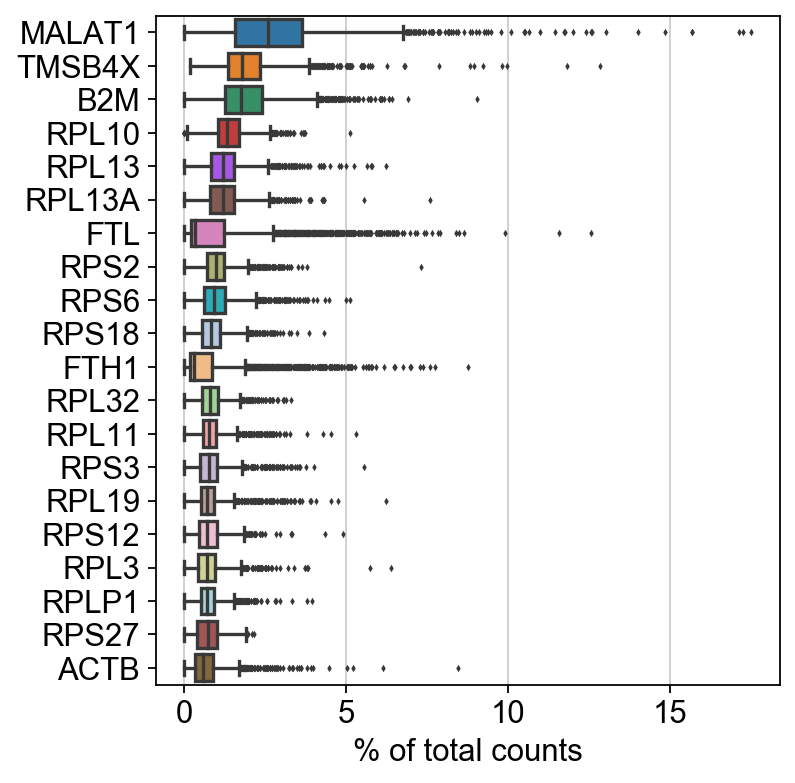

In [30]:
from tkinter import *
sc.pl.highest_expr_genes(adata, n_top=20, )

In [31]:
sc.pp.filter_cells(adata, min_genes = 500) ## filter out cells with less than 200 genes
sc.pp.filter_genes(adata, min_cells=3) ## filter out genes that are detected in less than 3 cells

filtered out 218 cells that have less than 500 genes expressed
filtered out 19109 genes that are detected in less than 3 cells


In [32]:
adata

AnnData object with n_obs × n_vars = 2482 × 13629 
    obs: 'n_genes'
    var: 'n_cells'

High proportions mitochondrial genes are indicative of poor-quality cells, possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.
With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

In [55]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

In [47]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]

In [53]:
# for each cell compute fraction of counts in mito genes vs all genes
# the '.A1' is only necessay, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis = 1).A1/np.sum(adata.X,axis=1).A1

## add the total counts per cell as observations-annotation to data
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Check number of genes, UMI counts and percent mito for all cells:

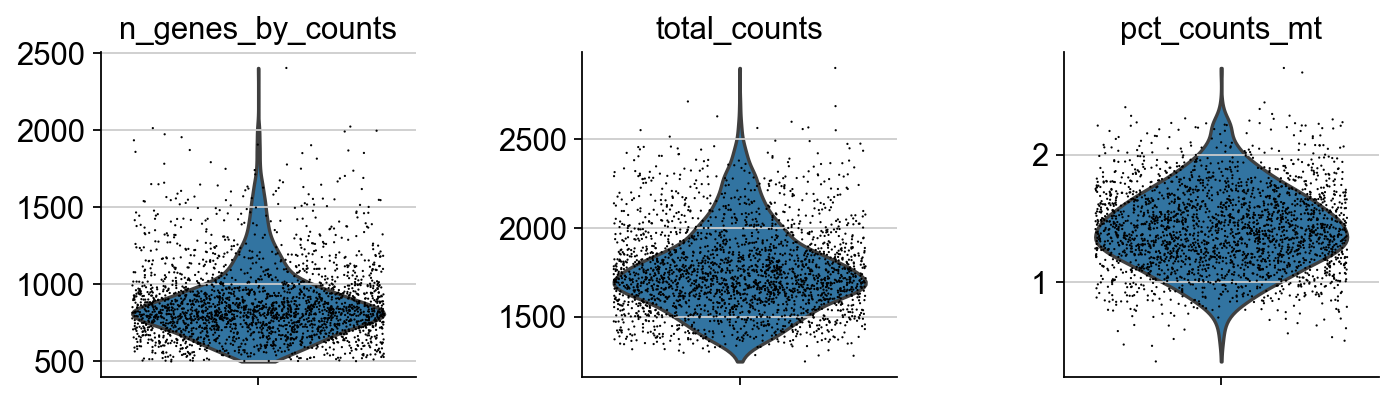

In [56]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

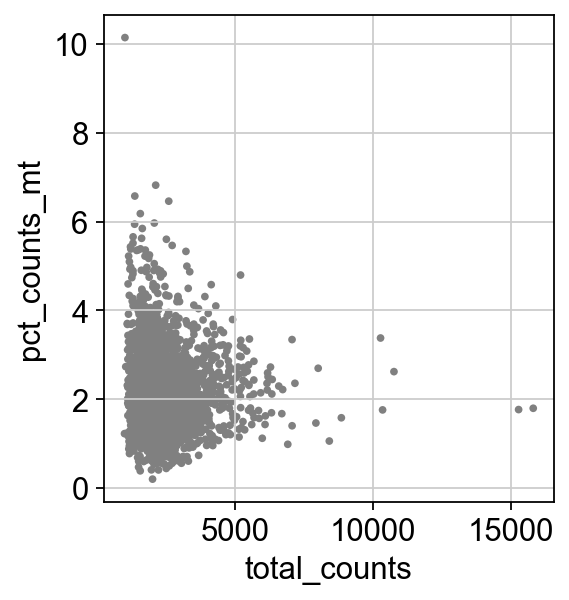

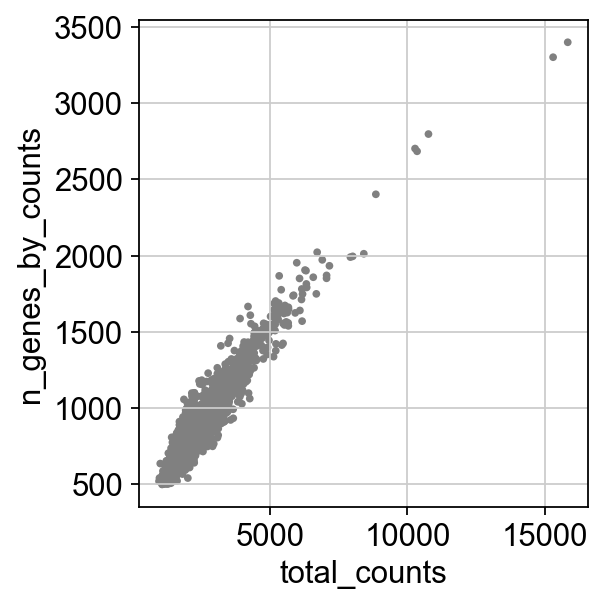

In [36]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [37]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [38]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:01)


In [39]:
sc.pp.log1p(adata)

/Users/apawar/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [40]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


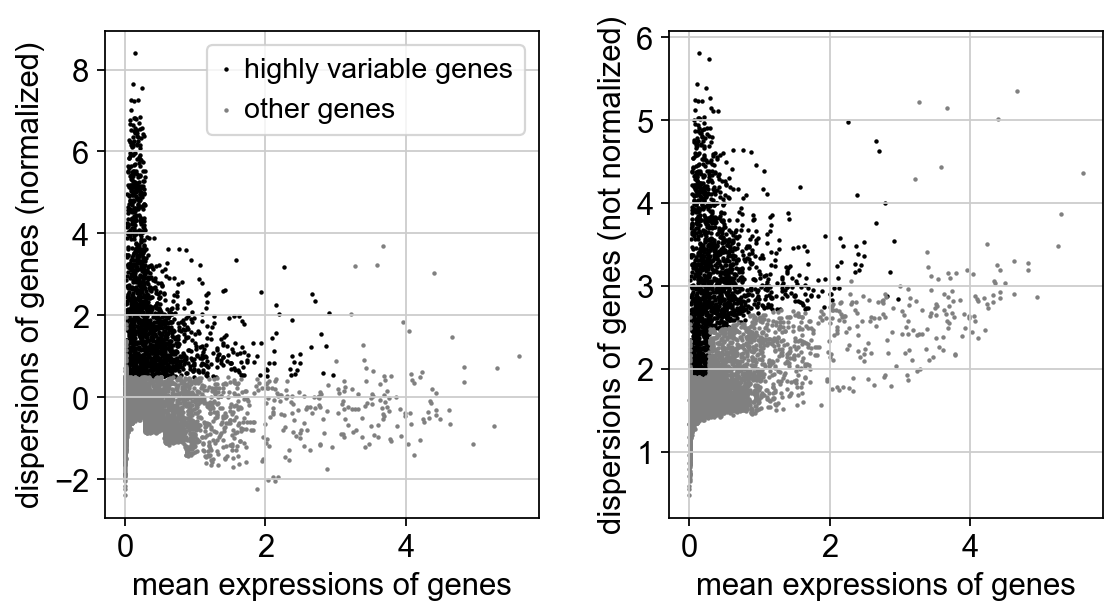

In [41]:
sc.pl.highly_variable_genes(adata)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

/Users/apawar/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

scanpy==1.4.6 anndata==0.7.1 umap==0.4.3 numpy==1.18.5 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0


In [3]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [4]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

In [5]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

In [6]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [7]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:01)
